In [ ]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load File paths

In [3]:
file_paths = [
    "./therapy/exp/05.15.25/long_gemma-2-2b-it_0_897.json",
    "./therapy/exp/05.15.25/long_Llama-3.1-8B-Instruct_0_336.json",
    "./therapy/exp/05.15.25/long_mistral-instruct_0_959.json"
]

In [12]:
data = []
for path in file_paths:
    with open(path, 'r') as f:
        data.append(json.load(f))

flat_data = [item for sublist in data for item in sublist]

In [ ]:
import re

model_names = []
for path, records in zip(file_paths, data):
    match = re.search(r'long_([^_]+)', os.path.basename(path))
    model_name = match.group(1) if match else ''
    model_names.extend([model_name] * len(records))

for record, model_name in zip(flat_data, model_names):
    record['model_name'] = model_name

df = pd.DataFrame(flat_data)


In [25]:
file_paths2 = [
    "./therapy/exp/05.14.25.marwa/gemma-2-2b-it_10_259.json",
    "./therapy/exp/05.14.25.marwa/Llama-3.1-8B-Instruct_10_932.json",
    "./therapy/exp/05.14.25.marwa/mistral-instruct_10_186.json",
    "./therapy/exp/05.14.25.marwa/mistral-instruct_0_501.json",
    "./therapy/exp/05.14.25.marwa/mistral-instruct_0_261.json"
]

In [ ]:
# Load data from file_paths2 and append to the existing dataframe df

data2 = []
for path in file_paths2:
    with open(path, 'r') as f:
        data2.append(json.load(f))

flat_data2 = [item for sublist in data2 for item in sublist]

model_names2 = []
for path, records in zip(file_paths2, data2):
    match = re.search(r'([^/]+?)(?:_\d+_\d+)?\.json$', os.path.basename(path))
    model_name = match.group(1) if match else ''
    model_names2.extend([model_name] * len(records))

for record, model_name in zip(flat_data2, model_names2):
    record['model_name'] = model_name

df2 = pd.DataFrame(flat_data2)

# Concatenate with the existing df
df = pd.concat([df, df2], ignore_index=True)

In [32]:
df.head()

,task_name,topic,grade,P1,P2,conversation,pturn,index,timestamp,rounds,conversation_only,model_name,eval_prompt_consistency,P2_prompt_consistency_score,eval_index_consistency,P2_index_consistency_score,P2_survey_consistency_score,P2_backstory_test,eval_survey_consistency,P1_prompt_consistency_score
0,Therapy,,,,"You are Alex, a 34-year-old IT technician with...","[[0, Therapist: Welcome! It's wonderful to mee...",1,0,2025-05-15 12:16:42,200,True,gemma-2-2b-it,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Therapy,,,,"You are Alex, a 34-year-old IT technician with...","[[0, Therapist: You mentioned that you feel st...",1,0,2025-05-15 12:48:10,200,True,Llama-3.1-8B-Instruct,"[[1, The intention behind the patient's statem...",0.450000,"[[3, This line is consistent with the conversa...",0.989899,3.650000,[[Question: You've just successfully debugged ...,"[[Patient: Honestly, I just feel like I'm not ...",NaN
2,Therapy,,,,"You are Alex, a 34-year-old IT technician with...","[[0, Therapist: How has this struggle been imp...",1,1,2025-05-15 12:50:32,300,True,Llama-3.1-8B-Instruct,"[[1, The intention behind this statement is fo...",0.306667,"[[3, The line is consistent with the previous ...",0.998658,3.653333,[[Question: You've just fixed a critical issue...,"[[Patient: To be honest, I think I push people...",NaN
3,Therapy,,,,"You are Riley, a 28-year-old freelance artist ...","[[0, Therapist: How can you tell it's been a y...",1,2,2025-05-15 12:52:02,200,True,Llama-3.1-8B-Instruct,"[[1, The intention behind the patient's line i...",0.050000,"[[3, This line is consistent with the patient'...",0.997172,3.930000,[[Question: As someone who keeps conversations...,[[Patient: It still feels like it happened yes...,NaN
4,Therapy,,,,"You are Riley, a 28-year-old freelance artist ...","[[0, Therapist: What's been on your mind latel...",1,3,2025-05-15 12:54:22,300,True,Llama-3.1-8B-Instruct,"[[1, The intention behind this line appears to...",0.066667,"[[3, The current line does not seem to have an...",0.994631,2.386667,[[Question: When someone asks you about your f...,[[Patient: I've been struggling to meet deadli...,NaN


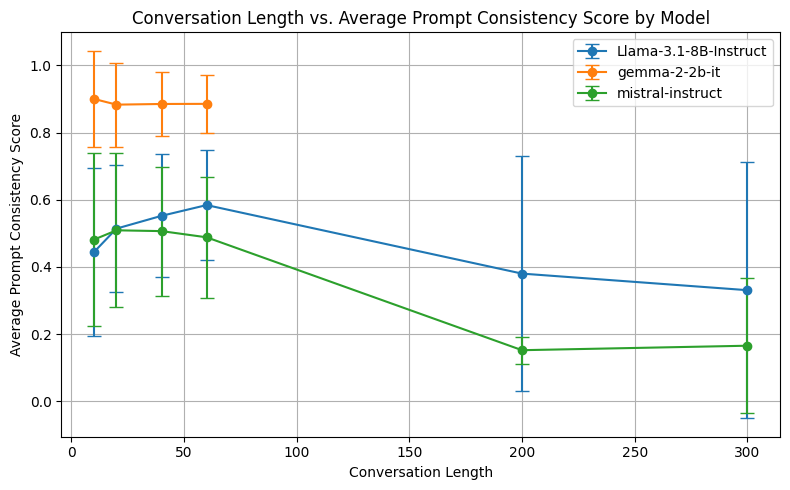

In [ ]:
# Group by conversation length and model name
grouped = df.groupby(['model_name', 'rounds']).agg(
    conversation_len=('conversation', lambda x: len(x.iloc[0]) if len(x) > 0 else 0),
    avg_prompt_consistency=('P2_prompt_consistency_score', 'mean'),
    std_prompt_consistency=('P2_prompt_consistency_score', 'std')
).reset_index()

plt.figure(figsize=(8, 5))
for model in grouped['model_name'].unique():
    model_data = grouped[grouped['model_name'] == model]
    plt.errorbar(
        model_data['conversation_len'],
        model_data['avg_prompt_consistency'],
        yerr=model_data['std_prompt_consistency'],
        marker='o',
        label=model,
        capsize=5
    )

plt.xlabel('Conversation Length')
plt.ylabel('Average Prompt Consistency Score')
plt.title('Conversation Length vs. Average Prompt Consistency Score by Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

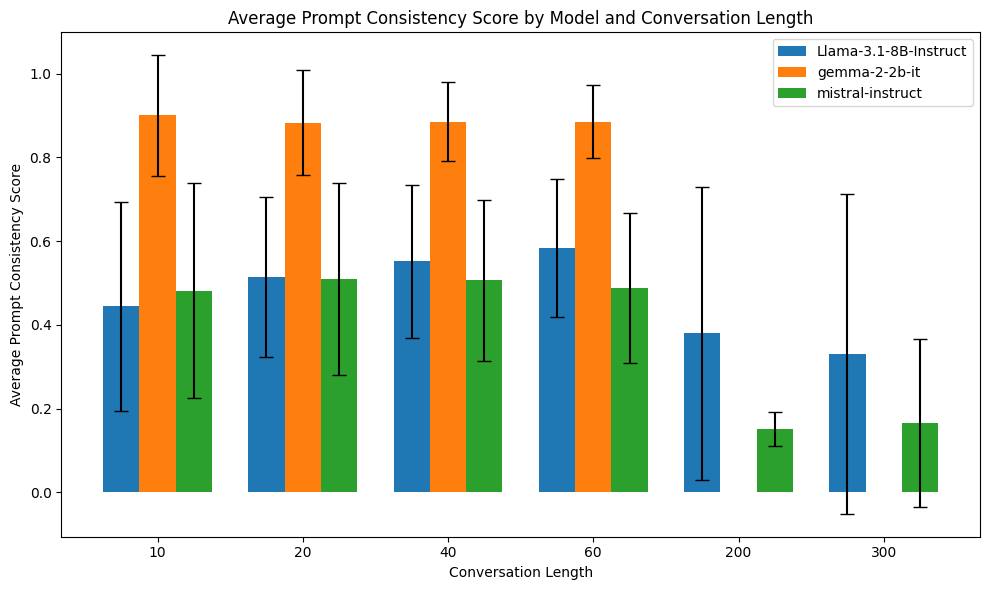

In [42]:
# Side-by-side bar plot for each model and conversation length

plot_data = grouped.dropna(subset=['avg_prompt_consistency'])

models = plot_data['model_name'].unique()
x = plot_data['conversation_len'].unique()
x.sort()
bar_width = 0.25
positions = np.arange(len(x))

plt.figure(figsize=(10, 6))

for i, model in enumerate(models):
    model_data = plot_data[plot_data['model_name'] == model]
    # Align bars for missing conversation lengths
    y = []
    yerr = []
    for conv_len in x:
        row = model_data[model_data['conversation_len'] == conv_len]
        if not row.empty:
            y.append(row['avg_prompt_consistency'].values[0])
            yerr.append(row['std_prompt_consistency'].values[0])
        else:
            y.append(np.nan)
            yerr.append(0)
    plt.bar(positions + i * bar_width, y, bar_width, yerr=yerr, label=model, capsize=5)

plt.xlabel('Conversation Length')
plt.ylabel('Average Prompt Consistency Score')
plt.title('Average Prompt Consistency Score by Model and Conversation Length')
plt.xticks(positions + bar_width, x)
plt.legend()
plt.tight_layout()
plt.show()

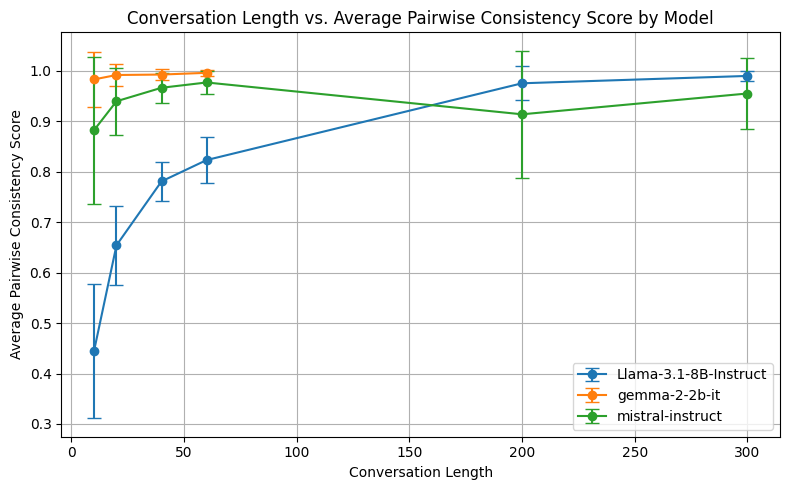

In [44]:
# Same plot for P2_index_consistency_score
grouped_index = df.groupby(['model_name', 'rounds']).agg(
    conversation_len=('conversation', lambda x: len(x.iloc[0]) if len(x) > 0 else 0),
    avg_index_consistency=('P2_index_consistency_score', 'mean'),
    std_index_consistency=('P2_index_consistency_score', 'std')
).reset_index()

plt.figure(figsize=(8, 5))
for model in grouped_index['model_name'].unique():
    model_data = grouped_index[grouped_index['model_name'] == model]
    plt.errorbar(
        model_data['conversation_len'],
        model_data['avg_index_consistency'],
        yerr=model_data['std_index_consistency'],
        marker='o',
        label=model,
        capsize=5
    )

plt.xlabel('Conversation Length')
plt.ylabel('Average Pairwise Consistency Score')
plt.title('Conversation Length vs. Average Pairwise Consistency Score by Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

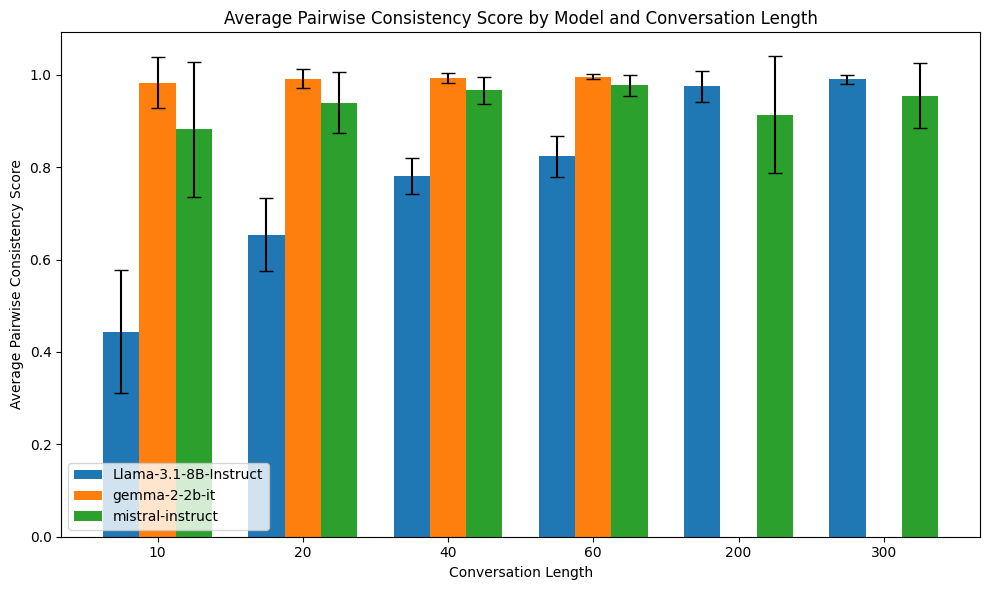

In [ ]:
# Bar plot for P2_index_consistency_score

plot_data_index = grouped_index.dropna(subset=['avg_index_consistency'])

models = plot_data_index['model_name'].unique()
x = plot_data_index['conversation_len'].unique()
x.sort()
bar_width = 0.25
positions = np.arange(len(x))

plt.figure(figsize=(10, 6))

for i, model in enumerate(models):
    model_data = plot_data_index[plot_data_index['model_name'] == model]
    y = []
    yerr = []
    for conv_len in x:
        row = model_data[model_data['conversation_len'] == conv_len]
        if not row.empty:
            y.append(row['avg_index_consistency'].values[0])
            yerr.append(row['std_index_consistency'].values[0])
        else:
            y.append(np.nan)
            yerr.append(0)
    plt.bar(positions + i * bar_width, y, bar_width, yerr=yerr, label=model, capsize=5)

plt.xlabel('Conversation Length')
plt.ylabel('Average Pairwise Consistency Score')
plt.title('Average Pairwise Consistency Score by Model and Conversation Length')
plt.xticks(positions + bar_width, x)
plt.legend()
plt.tight_layout()
plt.show()

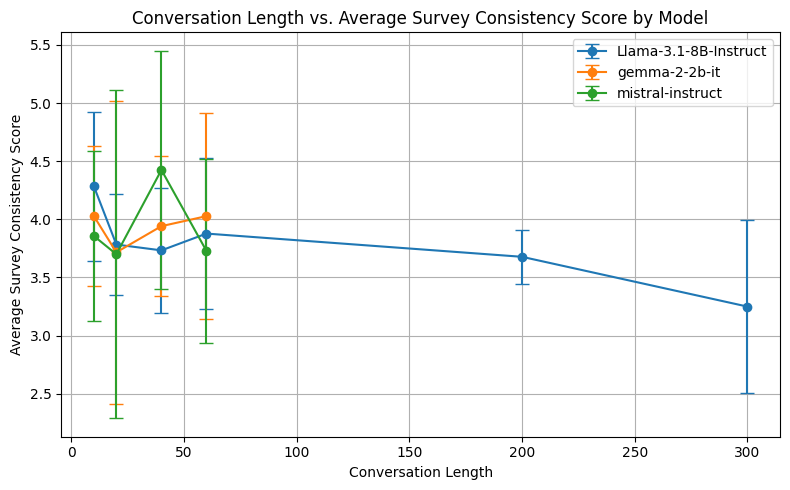

In [ ]:
# Survey consistency line plot

grouped_survey = df.groupby(['model_name', 'rounds']).agg(
    conversation_len=('conversation', lambda x: len(x.iloc[0]) if len(x) > 0 else 0),
    avg_survey_consistency=('P2_survey_consistency_score', 'mean'),
    std_survey_consistency=('P2_survey_consistency_score', 'std')
).reset_index()

plot_data_survey = grouped_survey.dropna(subset=['avg_survey_consistency'])

plt.figure(figsize=(8, 5))
for model in plot_data_survey['model_name'].unique():
    model_data = plot_data_survey[plot_data_survey['model_name'] == model]
    plt.errorbar(
        model_data['conversation_len'],
        model_data['avg_survey_consistency'],
        yerr=model_data['std_survey_consistency'],
        marker='o',
        label=model,
        capsize=5
    )

plt.xlabel('Conversation Length')
plt.ylabel('Average Survey Consistency Score')
plt.title('Conversation Length vs. Average Survey Consistency Score by Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


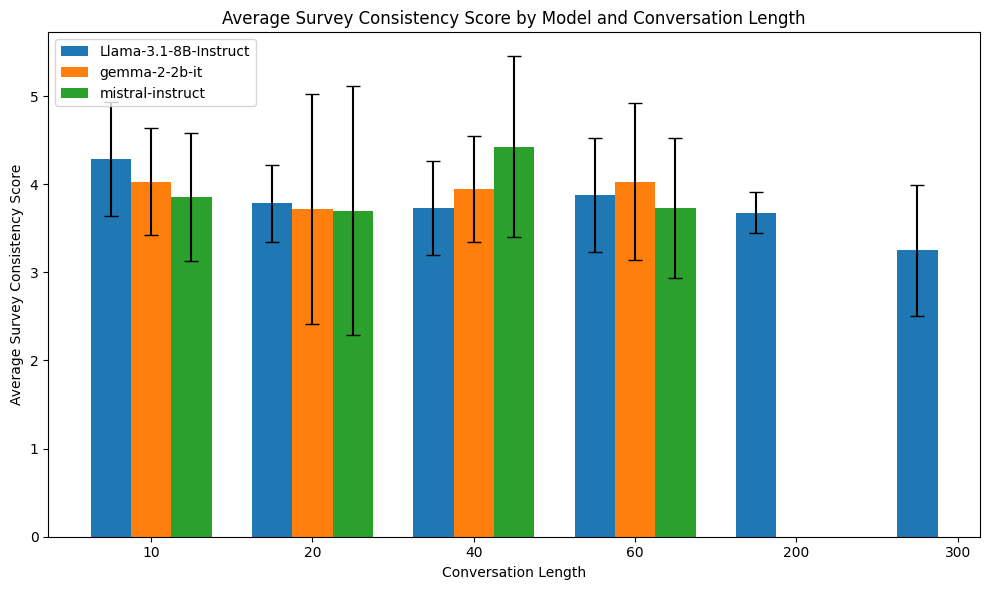

In [ ]:
# Survey consistency bar plot

models = plot_data_survey['model_name'].unique()
x = plot_data_survey['conversation_len'].unique()
x.sort()
bar_width = 0.25
positions = np.arange(len(x))

plt.figure(figsize=(10, 6))

for i, model in enumerate(models):
    model_data = plot_data_survey[plot_data_survey['model_name'] == model]
    y = []
    yerr = []
    for conv_len in x:
        row = model_data[model_data['conversation_len'] == conv_len]
        if not row.empty:
            y.append(row['avg_survey_consistency'].values[0])
            yerr.append(row['std_survey_consistency'].values[0])
        else:
            y.append(np.nan)
            yerr.append(0)
    plt.bar(positions + i * bar_width, y, bar_width, yerr=yerr, label=model, capsize=5)

plt.xlabel('Conversation Length')
plt.ylabel('Average Survey Consistency Score')
plt.title('Average Survey Consistency Score by Model and Conversation Length')
plt.xticks(positions + bar_width, x)
plt.legend()
plt.tight_layout()
plt.show()